Improting all libraries:

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

Even though all the images are supposed to be 64x64, let's apply transofrmation just in case

In [4]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),        #converting images to tensors
])

We downloaded all 27,000 pictures from GitHub, loaded them in, and applied transformation

In [14]:
# Assuming the script is in the project folder
data_dir = "./EuroSAT_RGB"
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

Splitting the data

In [15]:
#calculating the lengths for training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

#splitting the data
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [16]:
#putting our splits into batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
#verifying the total number of images, and sizes of the split sets
print(f"Total images: {len(dataset)}")
print(f"Training set: {len(train_dataset)} images")
print(f"Test set: {len(test_dataset)} images")

Total images: 27000
Training set: 21600 images
Test set: 5400 images


We wanted to achieve the most optimal result that will yield the highest accuracy while taking a reasonable time to train.
To do this, we craeted 3 convolutional layers (3->16->32->64). The reason for 3 input channels is because of input image's RGB colors. They are transformed into 16, then into 32, and finally into 64 channels for deeper understanding of patterns. 

Then we used a pooling layer to make it more efficient. It reduces the layer's dimension by 2 (e.g., 64x64 -> 32x32).

We have two Fully connected layers. The first one takes the output of the last convolutional layer: our number of channels is 64 (from our conv3) * 8*8 (if every layer gets pooled, then it transforms in the following way 64x64 -> 32x32 -> 16x16 -> 8x8) = 4096. Then it reduces it to 512 (arbitrary number that felt reasonable), and then passes it to the last fully connected layer that maps 512 channels into 11 output classes.

For the "forward" action, the model pools every convolutional layer, then flattens it into a single line, and gives us the prediction. Activation function is ReLU.


In [18]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=11): #11 types of land
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  
        self.fc1 = nn.Linear(64 * 8 * 8, 512) 
        self.fc2 = nn.Linear(512, num_classes)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 8 * 8)  #flattening into a single line
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=11)

#defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


print(model)


SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=11, bias=True)
)


In [34]:
#for a way faster processing, we try to put the computation on the GPU; if fails, it proceeds with CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10

#our training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Loop over the training data
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)  # Move data to the device

        optimizer.zero_grad()  #clearing the gradients

        outputs = model(images)  #forward pass
        loss = criterion(outputs, labels)  #loss
        loss.backward()  #backward pass
        optimizer.step()  #updating the weights

        #track training loss and accuracy
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    #calculate average loss and accuracy
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    #validating the model at each epoch
    model.eval() 
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    print(f"Validation Accuracy after Epoch {epoch+1}: {val_acc:.2f}%\n")

print("Training complete.")


100%|██████████| 675/675 [02:46<00:00,  4.06it/s]


Epoch [1/10], Loss: 1.2260, Accuracy: 53.63%
Validation Accuracy after Epoch 1: 69.06%



100%|██████████| 675/675 [00:41<00:00, 16.19it/s]


Epoch [2/10], Loss: 0.7623, Accuracy: 72.41%
Validation Accuracy after Epoch 2: 74.94%



100%|██████████| 675/675 [00:41<00:00, 16.21it/s]


Epoch [3/10], Loss: 0.6156, Accuracy: 77.60%
Validation Accuracy after Epoch 3: 79.96%



100%|██████████| 675/675 [00:41<00:00, 16.22it/s]


Epoch [4/10], Loss: 0.5321, Accuracy: 81.00%
Validation Accuracy after Epoch 4: 81.02%



100%|██████████| 675/675 [00:41<00:00, 16.28it/s]


Epoch [5/10], Loss: 0.4570, Accuracy: 83.58%
Validation Accuracy after Epoch 5: 77.59%



100%|██████████| 675/675 [00:42<00:00, 15.74it/s]


Epoch [6/10], Loss: 0.4191, Accuracy: 85.08%
Validation Accuracy after Epoch 6: 84.30%



100%|██████████| 675/675 [00:41<00:00, 16.12it/s]


Epoch [7/10], Loss: 0.3598, Accuracy: 87.24%
Validation Accuracy after Epoch 7: 84.11%



100%|██████████| 675/675 [00:41<00:00, 16.30it/s]


Epoch [8/10], Loss: 0.2954, Accuracy: 89.47%
Validation Accuracy after Epoch 8: 84.43%



100%|██████████| 675/675 [00:41<00:00, 16.29it/s]


Epoch [9/10], Loss: 0.2583, Accuracy: 91.15%
Validation Accuracy after Epoch 9: 83.83%



100%|██████████| 675/675 [00:41<00:00, 16.39it/s]


Epoch [10/10], Loss: 0.2151, Accuracy: 92.39%
Validation Accuracy after Epoch 10: 85.39%

Training complete.


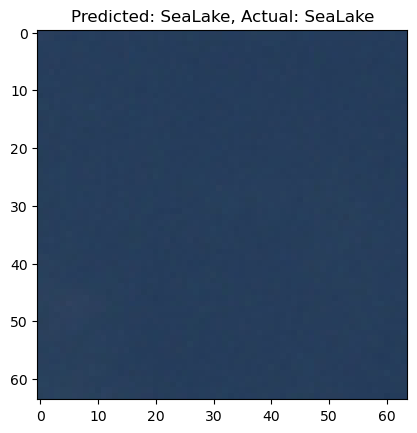

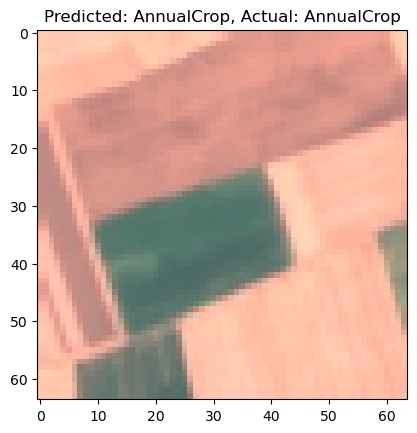

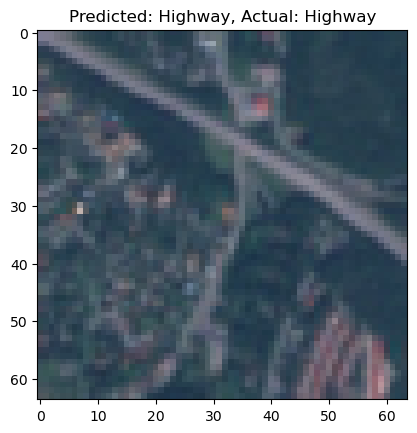

In [69]:

def imshow(img, title):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

#a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

#speeding up everything using GPU if possible
images, labels = images.to(device), labels.to(device)

#getting the predicted classes
outputs = model(images)
_, predicted = torch.max(outputs, 1)

#for loop to display predictions on the test set
for i in range(25): 
    imshow(images[i].cpu(), title=f"Predicted: {dataset.classes[predicted[i]]}, Actual: {dataset.classes[labels[i]]}")


Building a confusion matrix

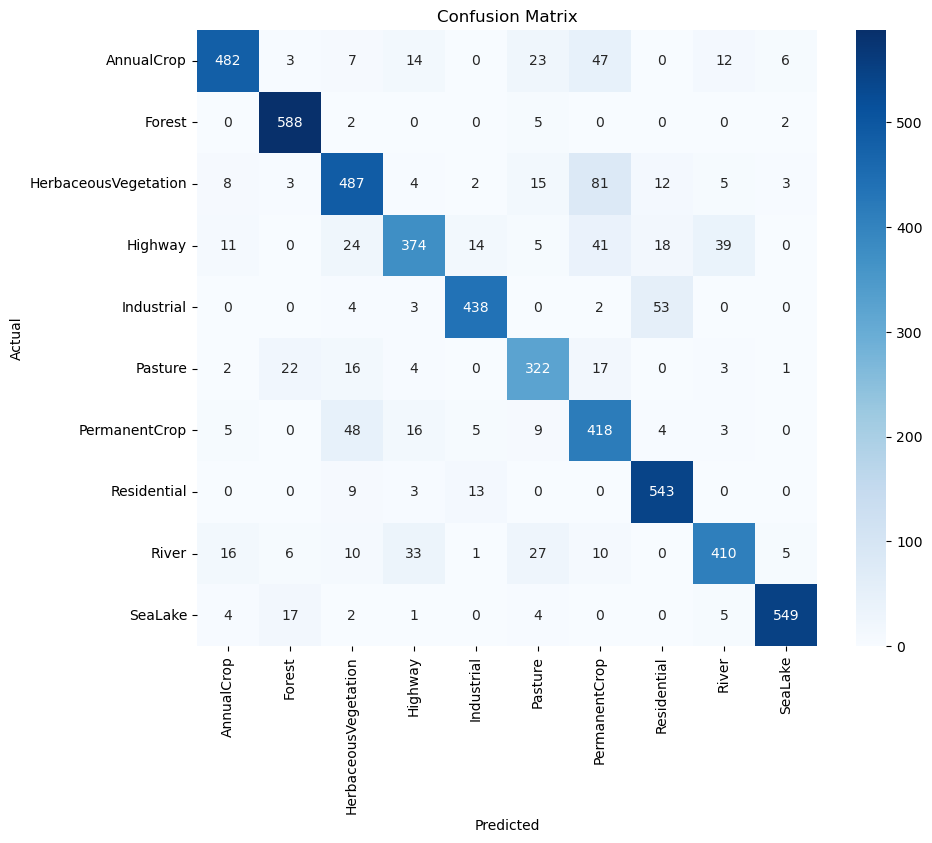

In [76]:
# Get all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm, index=dataset.classes, columns=dataset.classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Our model can predict distrinct classes well enough, yet it makes mistakes in visually similar classes. 
For example: 
* Highway vs River (a single line or a curve; both look similar)
* PermanentCrop vs HerbaceousVegetation (the model makes makes a mistake when PermanentCrop fields don't have clear visual lines)
* Highway vs PermanentCrop (the model makes a mistake when PermanentCrop has very distinct lines/curves resembling highways)
* etc.

The conclusion is that the model can produce very good results in terms of differentiating the distinct classes, but may make mistakes in visually similar ones. This could be potentially solved by making the model more complex, yet it might result in overfitting for visually distinct classes. It would be more beneficial to train visually similar classes separately from the rest.